In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Simulated Matches

In [3]:
df = pd.read_csv('../results/simulated_matches.csv')
print(f"Total simulated matches: {len(df)}")
df.head(15)

Total simulated matches: 123281


,simulation,match,match_type,opponent_team,player_elo,opponent_elo,win_elo,delta_elo,win_ml,delta_ml
0,1,1,league,Mandement,1468,1721,0,-0.772888,0,-0.772888
1,1,2,league,Mandement,1468,1270,1,1.392451,1,1.392451
2,1,3,league,Mandement,1468,1521,0,-5.280255,0,-5.280255
3,1,4,league,Bulle,1468,1592,0,-2.902087,0,-2.902087
4,1,5,league,Bulle,1468,1676,0,-1.253679,0,-1.253679
5,1,6,league,Bulle,1468,1533,0,-4.817746,1,10.182254
6,1,7,national,National,1468,1370,1,3.667217,1,3.667217
7,1,8,national,National,1468,970,1,0.048382,1,0.048382
8,1,9,national,National,1468,1255,1,1.189109,1,1.189109
9,1,10,national,National,1468,1413,1,5.201742,1,5.201742


## Summary Statistics

In [4]:
# Group by simulation to get final Elo for each
sim_results = df.groupby('simulation').agg({
    'delta_elo': 'sum',
    'delta_ml': 'sum',
    'win_elo': 'sum',
    'win_ml': 'sum'
}).reset_index()

PLAYER_ELO = 1468
sim_results['final_elo_swiss'] = PLAYER_ELO + sim_results['delta_elo']
sim_results['final_elo_ml'] = PLAYER_ELO + sim_results['delta_ml']

print("=== Swiss Elo Formula ===")
print(f"Mean final Elo: {sim_results['final_elo_swiss'].mean():.1f}")
print(f"Std deviation: {sim_results['final_elo_swiss'].std():.1f}")
print(f"Min: {sim_results['final_elo_swiss'].min():.1f}, Max: {sim_results['final_elo_swiss'].max():.1f}")
print(f"90% interval: [{sim_results['final_elo_swiss'].quantile(0.05):.1f}, {sim_results['final_elo_swiss'].quantile(0.95):.1f}]")

print("\n=== ML Model ===")
print(f"Mean final Elo: {sim_results['final_elo_ml'].mean():.1f}")
print(f"Std deviation: {sim_results['final_elo_ml'].std():.1f}")
print(f"Min: {sim_results['final_elo_ml'].min():.1f}, Max: {sim_results['final_elo_ml'].max():.1f}")
print(f"90% interval: [{sim_results['final_elo_ml'].quantile(0.05):.1f}, {sim_results['final_elo_ml'].quantile(0.95):.1f}]")

=== Swiss Elo Formula ===
Mean final Elo: 1468.1
Std deviation: 17.4
Min: 1403.0, Max: 1534.9
90% interval: [1439.4, 1497.1]

=== ML Model ===
Mean final Elo: 1470.3
Std deviation: 18.3
Min: 1405.3, Max: 1548.6
90% interval: [1440.0, 1500.2]


## Final Elo Distribution

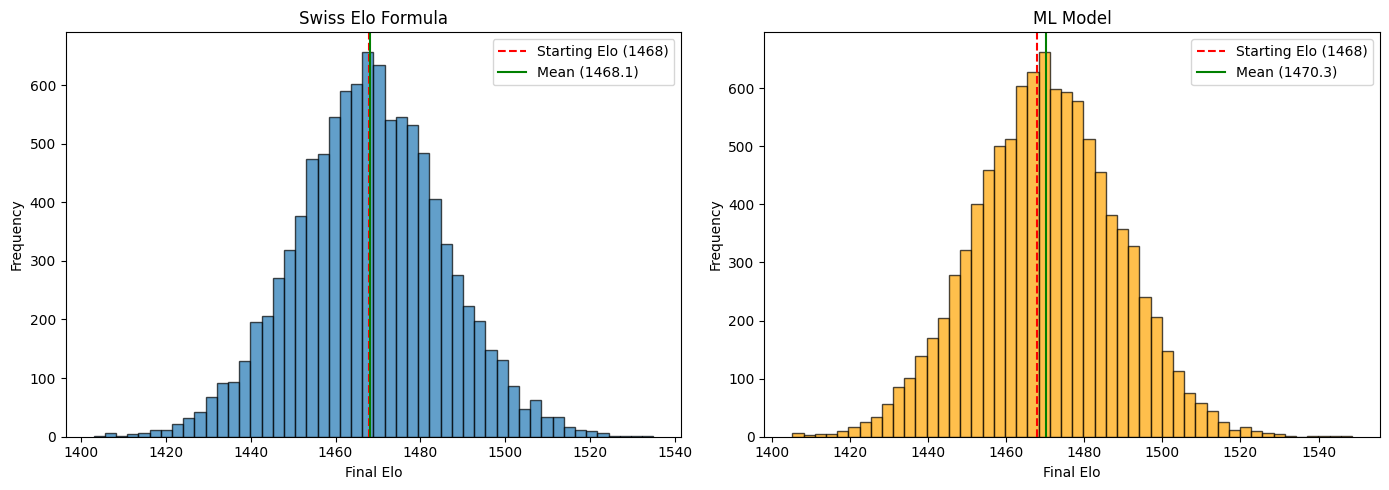

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Swiss Elo
axes[0].hist(sim_results['final_elo_swiss'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(PLAYER_ELO, color='red', linestyle='--', label=f'Starting Elo ({PLAYER_ELO})')
axes[0].axvline(sim_results['final_elo_swiss'].mean(), color='green', linestyle='-', label=f'Mean ({sim_results["final_elo_swiss"].mean():.1f})')
axes[0].set_xlabel('Final Elo')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Swiss Elo Formula')
axes[0].legend()

# ML Model
axes[1].hist(sim_results['final_elo_ml'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(PLAYER_ELO, color='red', linestyle='--', label=f'Starting Elo ({PLAYER_ELO})')
axes[1].axvline(sim_results['final_elo_ml'].mean(), color='green', linestyle='-', label=f'Mean ({sim_results["final_elo_ml"].mean():.1f})')
axes[1].set_xlabel('Final Elo')
axes[1].set_ylabel('Frequency')
axes[1].set_title('ML Model')
axes[1].legend()

plt.tight_layout()
plt.show()

## Win Rate by Match Type

In [6]:
win_rates = df.groupby(['match_type', 'opponent_team']).agg({
    'win_elo': 'mean',
    'win_ml': 'mean',
    'opponent_elo': 'mean'
}).round(3)

win_rates.columns = ['Win Rate (Swiss)', 'Win Rate (ML)', 'Avg Opponent Elo']
win_rates

Win Rate (Swiss)  Win Rate (ML)  Avg Opponent Elo
match_type opponent_team                                                   
league     Bulle                     0.219          0.260          1589.119
           Mandement                 0.265          0.277          1630.828
national   National                  0.683          0.684          1368.826

## Win Rate vs Elo Difference

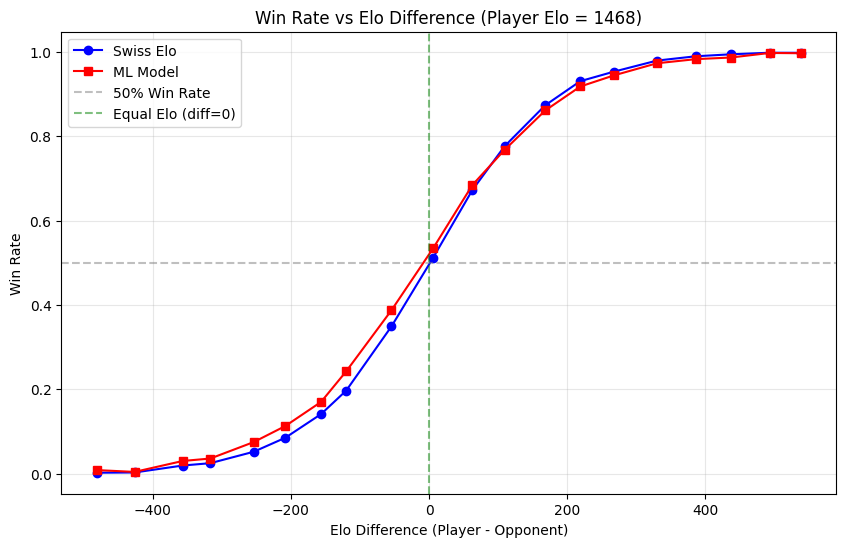

In [7]:
# Calculate Elo difference (Player Elo - Opponent Elo)
df['elo_diff'] = PLAYER_ELO - df['opponent_elo']

# Bin by Elo difference and calculate win rate
df['elo_diff_bin'] = pd.cut(df['elo_diff'], bins=20)
elo_win_rate = df.groupby('elo_diff_bin', observed=True).agg({
    'win_elo': 'mean',
    'win_ml': 'mean',
    'elo_diff': ['mean', 'count']
}).dropna()

plt.figure(figsize=(10, 6))
plt.plot(elo_win_rate['elo_diff']['mean'], elo_win_rate['win_elo']['mean'], 'b-o', label='Swiss Elo')
plt.plot(elo_win_rate['elo_diff']['mean'], elo_win_rate['win_ml']['mean'], 'r-s', label='ML Model')
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='50% Win Rate')
plt.axvline(0, color='green', linestyle='--', alpha=0.5, label='Equal Elo (diff=0)')
plt.xlabel('Elo Difference (Player - Opponent)')
plt.ylabel('Win Rate')
plt.title(f'Win Rate vs Elo Difference (Player Elo = {PLAYER_ELO})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Total Wins per Simulation

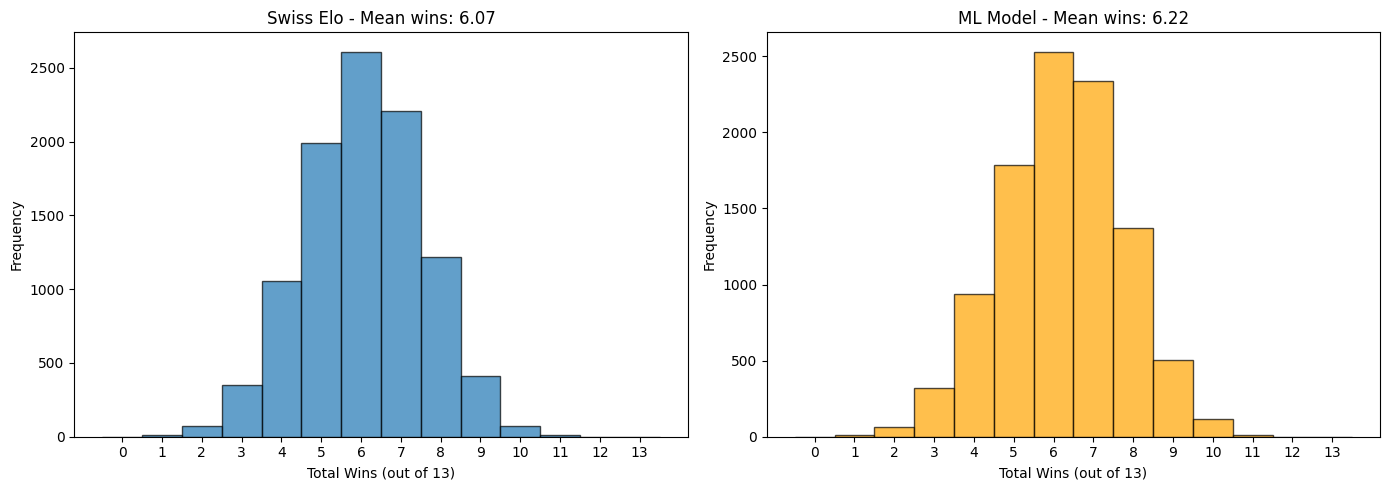

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Swiss Elo wins
axes[0].hist(sim_results['win_elo'], bins=range(0, 15), edgecolor='black', alpha=0.7, align='left')
axes[0].set_xlabel('Total Wins (out of 13)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Swiss Elo - Mean wins: {sim_results["win_elo"].mean():.2f}')
axes[0].set_xticks(range(0, 14))

# ML wins
axes[1].hist(sim_results['win_ml'], bins=range(0, 15), edgecolor='black', alpha=0.7, color='orange', align='left')
axes[1].set_xlabel('Total Wins (out of 13)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'ML Model - Mean wins: {sim_results["win_ml"].mean():.2f}')
axes[1].set_xticks(range(0, 14))

plt.tight_layout()
plt.show()

## Win/Loss Scatter Plot (Player Elo vs Opponent Elo)

Historical matches: 31,492
Player Elo range: 793 - 1958


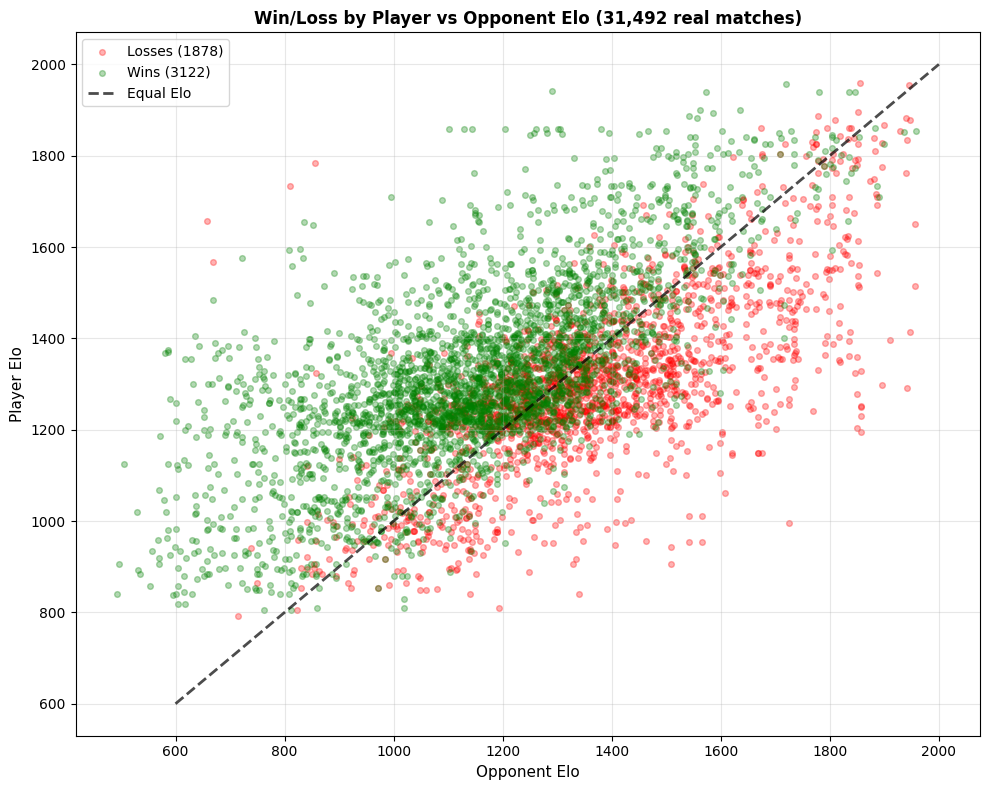

In [28]:
# Load historical matches (real scraped data from click-tt.ch)
hist_df = pd.read_csv('../data/raw/historical_matches.csv')
print(f"Historical matches: {len(hist_df):,}")
print(f"Player Elo range: {hist_df['player_elo'].min():.0f} - {hist_df['player_elo'].max():.0f}")

# Sample for visualization
sample_size = min(5000, len(hist_df))
sample = hist_df.sample(n=sample_size, random_state=42)

wins = sample[sample['win'] == 1]
losses = sample[sample['win'] == 0]

plt.figure(figsize=(10, 8))

# Scatter plot: Player Elo vs Opponent Elo
plt.scatter(losses['opponent_elo'], losses['player_elo'], c='red', alpha=0.3, label=f'Losses ({len(losses)})', s=17)
plt.scatter(wins['opponent_elo'], wins['player_elo'], c='green', alpha=0.3, label=f'Wins ({len(wins)})', s=17)
plt.plot([600, 2000], [600, 2000], 'k--', alpha=0.7, linewidth=2, label='Equal Elo')

plt.xlabel('Opponent Elo', fontsize=11)
plt.ylabel('Player Elo', fontsize=11)
plt.title(f'Win/Loss by Player vs Opponent Elo ({len(hist_df):,} real matches)', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
historical_df.head(10)

,simulation,match,match_type,opponent_team,player_elo,opponent_elo,win_elo,delta_elo,win_ml,delta_ml
0,1,1,league,Mandement,1468,1721,0,-0.772888,0,-0.772888
1,1,2,league,Mandement,1468,1270,1,1.392451,1,1.392451
2,1,3,league,Mandement,1468,1521,0,-5.280255,0,-5.280255
3,1,4,league,Bulle,1468,1592,0,-2.902087,0,-2.902087
4,1,5,league,Bulle,1468,1676,0,-1.253679,0,-1.253679
5,1,6,league,Bulle,1468,1533,0,-4.817746,1,10.182254
6,1,7,national,National,1468,1370,1,3.667217,1,3.667217
7,1,8,national,National,1468,970,1,0.048382,1,0.048382
8,1,9,national,National,1468,1255,1,1.189109,1,1.189109
9,1,10,national,National,1468,1413,1,5.201742,1,5.201742


In [ ]:
# Use historical matches for scatter plot
# Sample a subset for better visualization
historical_df = pd.read_csv('../data/historical_matches.csv')

sample_hist = historical_df.sample(n=5000, random_state=42)

wins = sample_hist[sample_hist['win_elo'] == 1]
losses = sample_hist[sample_hist['win_elo'] == 0]

plt.figure(figsize=(10, 8))
plt.scatter(wins['opponent_elo'], wins['player_elo'], c='green', alpha=0.4, label=f'Wins ({len(wins)})', s=20)
plt.scatter(losses['opponent_elo'], losses['player_elo'], c='red', alpha=0.4, label=f'Losses ({len(losses)})', s=20)

# Add diagonal line (equal Elo)
plt.plot([400, 2000], [400, 2000], 'k--', alpha=0.5, label='Equal Elo')

plt.xlabel('Opponent Elo')
plt.ylabel('Player Elo')
plt.title('Win/Loss by Player Elo vs Opponent Elo (Historical Matches)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
historical_df = pd.read_csv('../data/historical_matches.csv')
historical_df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '../data/historical_matches.csv'